If using google drive please edit this line to connect to drive location

In [1]:
%load_ext autoreload
%autoreload 2


In [2]:
# from google.colab import drive
import os, sys

# # Mount the google colab
# drive.mount("/content/drive/")
# GOOGLE_DRIVE_PATH_POST_MYDRIVE = 'DeepLearning_GroupProject/'
# GOOGLE_DRIVE_PATH = os.path.join('/content', 'drive', 'MyDrive', GOOGLE_DRIVE_PATH_POST_MYDRIVE)
# !ls {GOOGLE_DRIVE_PATH}
# sys.path.append(GOOGLE_DRIVE_PATH)

GOOGLE_DRIVE_PATH = '.'


# relative paths
models_dir = 'models'
csv_path = 'Data/updated_data_with_lists.csv'
tensors_dir = 'Data/tensor_batch_notaugmented'

In [3]:
import pandas as pd
from ast import literal_eval
import numpy as np
import torch

# Explicitly adding models to the search path
models_path = os.path.join(GOOGLE_DRIVE_PATH, models_dir)
if models_path not in sys.path:
    sys.path.insert(0, models_path)

from models import recipe_encoder

csv_file = os.path.join(GOOGLE_DRIVE_PATH,csv_path)
df = pd.read_csv(csv_file, converters={"Cleaned_Ingredients": literal_eval, "Instructions": literal_eval})
print(len(df))
df.head()

13496


,Unnamed: 0,Title,Instructions,Image_Name,Cleaned_Ingredients
0,0,Miso-Butter Roast Chicken With Acorn Squash Pa...,"[Pat chicken dry with paper towels, season all...",miso-butter-roast-chicken-acorn-squash-panzanella,"[1 (3½–4-lb.) whole chicken, 2¾ tsp. kosher sa..."
1,1,Crispy Salt and Pepper Potatoes,[Preheat oven to 400°F and line a rimmed bakin...,crispy-salt-and-pepper-potatoes-dan-kluger,"[2 large egg whites, 1 pound new potatoes (abo..."
2,2,Thanksgiving Mac and Cheese,[Place a rack in middle of oven; preheat to 40...,thanksgiving-mac-and-cheese-erick-williams,"[1 cup evaporated milk, 1 cup whole milk, 1 ts..."
3,3,Italian Sausage and Bread Stuffing,[Preheat oven to 350°F with rack in middle. Ge...,italian-sausage-and-bread-stuffing-240559,"[1 (¾- to 1-pound) round Italian loaf, cut int..."
4,4,Newton's Law,[Stir together brown sugar and hot water in a ...,newtons-law-apple-bourbon-cocktail,"[1 teaspoon dark brown sugar, 1 teaspoon hot w..."


Concatenate the batches of preprocessed images into 1 tensor

In [4]:
import re
# Use natural sorting: https://stackoverflow.com/a/16090640
nat_sort = lambda s: [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

pt_files = sorted(os.listdir(os.path.join(GOOGLE_DRIVE_PATH,tensors_dir)), key=nat_sort)

all_image_tensors = []
all_image_labels = []

# Load and combine all .pt files
for pt_file in pt_files[:5]:  #[:1]:
    pt_filepath = os.path.join(GOOGLE_DRIVE_PATH,tensors_dir,pt_file)
    image_tensors, image_labels = torch.load(pt_filepath)
    all_image_tensors.append(image_tensors)
    all_image_labels.extend(image_labels)
    print(f"Loaded {pt_file}")

# Concatenate tensors
all_image_tensors = torch.cat(all_image_tensors)
print(f"Number of images: {all_image_tensors.size(0)}")
print(f"Number of labels: {len(all_image_labels)}")
assert all_image_tensors.size(0) == len(all_image_labels), "Mismatch between images and labels!"

/tmp/ipykernel_32801/1456529901.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  image_tensors, image_labels = torch.load(pt_filepath)


Loaded batch_0.pt
Loaded batch_1.pt
Loaded batch_2.pt
Loaded batch_3.pt
Loaded batch_4.pt
Number of images: 5000
Number of labels: 5000


Reorganize dataframe to be in the same order as the Image Tensors using the image_label as the matching key

In [5]:
##Reset order of dataframe to match the image labels orders
all_image_labels_cleaned = [label.split(".")[0] for label in all_image_labels] #remove the .png and .jgp
print(all_image_labels_cleaned[:10]) #print to see if at the end the df matches

filtered_df = df[df["Image_Name"].isin(all_image_labels_cleaned)] #filter the df to only have values from the images
print(filtered_df["Image_Name"][:10])
print(df.shape)
print(filtered_df.shape, len(all_image_labels_cleaned))

valid_labels = set(filtered_df['Image_Name'])

# Filter labels and tensors
filtered_labels_and_tensors = [
    (tensor, label) for tensor, label in zip(all_image_tensors, all_image_labels_cleaned) if label in valid_labels
]

# Unpack the filtered data
filtered_tensors, filtered_labels = zip(*filtered_labels_and_tensors)

# Convert back to tensors
filtered_tensors = torch.stack(filtered_tensors)
filtered_labels = list(filtered_labels)

# Verify alignment
print(f"Number of filtered tensors: {len(filtered_tensors)}")
print(f"Number of filtered labels: {len(filtered_labels)}")
print(f"Number of rows in filtered_df: {len(filtered_df)}")

# Finally reorganize the df to be in the same order as the image tensors
filtered_df = filtered_df.set_index("Image_Name").loc[filtered_labels].reset_index()
print(filtered_df["Image_Name"][:10])

['spanish-style-grilled-vegetables-with-breadcrumb-picada-238806', 'three-cheese-pizza-with-onion-sage-and-arugula-233543', 'speedy-skillet-ravioli-lasagna', 'summer-anchovy-salad-51108430', 'spice-roasted-cornish-hens-with-cucumber-yogurt-sauce-353418', 'stovetop-butterscotch-apples-and-cranberries', 'tarte-tatin-51196820', 'spanish-olive-and-cream-cheese-canapes-231160', 'spice-rubbed-sustainable-fish-sliders', 'spiced-pumpkin-layer-cake-240123']
2            thanksgiving-mac-and-cheese-erick-williams
5                  warm-comfort-tequila-chamomile-toddy
7                     turmeric-hot-toddy-claire-sprouse
9        spiced-lentil-and-caramelized-onion-baked-eggs
11          spiral-ham-in-the-slow-cooker-guarnaschelli
19    roasted-beets-with-crispy-sunchokes-and-pickle...
24    sloppy-joe-shirred-eggs-with-spinach-vivian-ho...
27                           spicy-coconut-pumpkin-soup
30                                trinidad-curry-powder
31                                  shrimp-

In [6]:
filtered_df.head()

,Image_Name,Unnamed: 0,Title,Instructions,Cleaned_Ingredients
0,spanish-style-grilled-vegetables-with-breadcru...,10787,Spanish-Style Grilled Vegetables with Breadcru...,[Prepare barbecue (medium heat). Arrange veget...,[3 large red bell peppers (about 1 1/2 pounds)...
1,three-cheese-pizza-with-onion-sage-and-arugula...,12145,"Three-Cheese Pizza with Onion, Sage, and Arugula",[Place pizza stone on floor of gas oven or on ...,[1 (1/4-oz) package active dry yeast (2 1/4 te...
2,speedy-skillet-ravioli-lasagna,551,Speedy Skillet Ravioli Lasagna,[Preheat the oven to 450°F with a rack in the ...,"[2 tbsp. extra-virgin olive oil, 2 large garli..."
3,summer-anchovy-salad-51108430,6117,Summer Anchovy Salad,[Cut tomatoes into fat wedges. Drizzle with ol...,"[Tomatoes, Olive oil, Splash of vinegar, Crumb..."
4,spice-roasted-cornish-hens-with-cucumber-yogur...,8769,Spice-Roasted Cornish Hens with Cucumber-Yogur...,[Position rack in top third of oven; preheat t...,"[3 1 1/4 to 1 1/2-pound Cornish game hens, spl..."


Reformat Ingredients, Recipes, and Image titles

Tokenize Recipes, Ingredients, and Image Titles

In [7]:

from transformers import AutoTokenizer
total_max = 128
# Initialize the tokenizer
tokenizer_recipes = AutoTokenizer.from_pretrained("bert-base-uncased")

def tokenize_nested_list(nested_list, max_length=128):
    """
    Tokenizes a nested list of strings (list of ingredients per recipe).
    Each inner list is tokenized into a list of token IDs.
    """
    tokenized_list = []
    for sublist in nested_list:
        # Join the inner list into a string
        # text = " ".join(sublist)
        text = str(sublist)
        # Tokenize the string
        tokens = tokenizer_recipes(
            text,
            max_length=max_length,
            padding="max_length",
            truncation=True,
            return_tensors="pt",
        )
        # Append tokenized input_ids to the result list
        tokenized_list.append(tokens["input_ids"].squeeze(0).tolist())
    return tokenized_list

filtered_df['Title_List'] = df['Title'].apply(lambda x: [x])
filtered_df['tokenized_ingredients'] = filtered_df['Cleaned_Ingredients'].apply(lambda x: tokenize_nested_list(x, total_max))
filtered_df['tokenized_instructions'] = filtered_df['Instructions'].apply(lambda x: tokenize_nested_list(x, total_max))
filtered_df['tokenized_titles'] = filtered_df['Title_List'].apply(lambda x: tokenize_nested_list(x, total_max))


# # Store tokenized data in a dictionary for your DataLoader
# filtered_df["tokenized_titles"] = title_tokens["input_ids"]
# filtered_df["title_attention_mask"] = title_tokens["attention_mask"]

# filtered_df["tokenized_ingredients"] = ingredients_tokens["input_ids"]
# filtered_df["ingredients_attention_mask"] = ingredients_tokens["attention_mask"]

# filtered_df["tokenized_instructions"] = instructions_tokens["input_ids"]
# filtered_df["instructions_attention_mask"] = instructions_tokens["attention_mask"]
print(len(filtered_df["tokenized_titles"][0]))
print(filtered_df["tokenized_ingredients"][0])
print(filtered_df["tokenized_instructions"][0])


/home/chelsea/anaconda3/envs/tfood_torch/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


1
[[101, 1017, 2312, 2417, 4330, 23582, 1006, 2055, 1015, 1015, 1013, 1016, 7038, 1007, 1010, 27674, 1010, 13916, 1010, 4284, 2098, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1018, 2312, 2887, 8288, 24759, 11390, 1006, 2055, 1015, 1015, 1013, 1018, 7038, 1007, 1010, 21920, 1010, 3013, 3091, 14244, 2046, 1017, 25609, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1018, 5396, 2665, 2030, 3756, 16950, 25955, 3490, 1006, 9544, 8231, 1016, 

In [8]:
def pad_or_truncate_nested(sublist, target_length, max_length, pad_token=0):
        """
            Pad or truncate the outer list of a nested list to match the target_length.
            Each inner list remains untouched.
        """
        # Pad with [pad_token] or truncate the outer list
        if len(sublist) < target_length:
            sublist.extend([[pad_token]* max_length] * (target_length - len(sublist)))
        else:
            sublist = sublist[:target_length]
        return sublist

max_length_ing = filtered_df['tokenized_ingredients'].apply(len).max()
max_length_inst = filtered_df['tokenized_instructions'].apply(len).max()//4
max_length_title = filtered_df['tokenized_titles'].apply(len).max()
filtered_df['tokenized_ingredients'] = filtered_df['tokenized_ingredients'].apply(
    lambda ing: pad_or_truncate_nested(ing, max_length_ing,total_max))

filtered_df['tokenized_instructions'] = filtered_df['tokenized_instructions'].apply(
    lambda inst: pad_or_truncate_nested(inst, max_length_inst, total_max))
# new_token_ing = [pad_or_truncate_nested(ing, max_length_title) for ing in tokenized_ingredients] #titles were all list length of 1
max_length_ing = filtered_df['tokenized_ingredients'].apply(len).max()
max_length_inst = filtered_df['tokenized_instructions'].apply(len).max()
max_length_title = filtered_df['tokenized_titles'].apply(len).max()
print(max_length_ing, max_length_inst, max_length_title)
print(len(filtered_df['tokenized_ingredients'][5]))
print(filtered_df['tokenized_ingredients'][100])

42 23 1
42
[[101, 1015, 1013, 1018, 2452, 9724, 3514, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1016, 3009, 24444, 1010, 20956, 1998, 4857, 2135, 15920, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1016, 2312, 18856, 21818, 2015, 20548, 1010, 20956, 1998, 24881, 1010, 4606, 1018, 18856, 21818, 2015, 2878, 20548, 1010, 20956, 102, 0, 0, 0, 0, 0, 0, 0,

Tokenize the Image Labels for the Image Encoder

In [9]:
from transformers import AutoTokenizer
from transformers import CLIPModel
model_name = "openai/clip-vit-base-patch16"
clip_model = CLIPModel.from_pretrained(model_name)
tokenizer_images = AutoTokenizer.from_pretrained(model_name)

tokenized_labels = tokenizer_images(
    filtered_labels,
    padding="max_length",
    truncation=True,
    max_length=tokenizer_images.model_max_length,
    return_tensors="pt"
)

/home/chelsea/anaconda3/envs/tfood_torch/lib/python3.12/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [10]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
%reload_ext autoreload


cuda:0


In [11]:
import torch.nn as nn
class RecipeDecoder(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, vocab_size):
        super(RecipeDecoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.rnn = nn.LSTM(embedding_dim, hidden_dim, batch_first=True)
        self.fc_out = nn.Linear(hidden_dim, vocab_size)
        self.hidden_dim = hidden_dim

    def forward(self, input_tokens):
        embedded = self.embedding(input_tokens)
        outputs, hidden_state = self.rnn(embedded, hidden_state)
        predictions = self.fc_out(outputs)
        return predictions

In [12]:
def calc_recall(top, image_features, recipe_embeddings, image_labels):
  true_pos = 0
  false_neg = 0
  tmp_batches = image_features.shape[0]
  print(image_features.shape, recipe_embeddings.shape)
  for i in range(tmp_batches):
    cosine_similarity = torch.nn.CosineSimilarity(dim=1)
    similarities = cosine_similarity(image_features[i, :].unsqueeze(0), recipe_embeddings)
    print(similarities)
    #top = amount of top results to retrieve
    top_results = top
    top_k_values, top_k_indices = torch.topk(similarities, top_results, largest=True)
    print(top_k_values, top_k_indices)
    top_images = [(filtered_df['Image_Name'][i]) for i in top_k_indices]
    if image_labels[i] in [image[0] for image in top_images]:
      true_pos += 1
    else:
      false_neg += 1

  return (true_pos / tmp_batches)


In [13]:
from torch.utils.data import Dataset, DataLoader, random_split
import torch
from models.image_2_recipe import Image2Recipe
from models.image_encoder import Image_Encoder
from models.recipe_encoder import RecipeEncoder
from models.MMR import MMR
from models.MMR import MMR_losses
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

class Data_Loading(Dataset):
    """
    Class to combine the Images, Labels, Recipes together to be used in combination when inputted into Model
    """
    def __init__(self, tokenized_ingredients, tokenized_instructions, tokenized_titles, image_tensors, image_labels):
        self.ingredients = torch.tensor(tokenized_ingredients, dtype=torch.int16)
        self.instructions = torch.tensor(tokenized_instructions, dtype=torch.int16)
        self.titles = torch.tensor(tokenized_titles, dtype=torch.int16)
        self.images = image_tensors
        self.image_labels = image_labels

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return {
            "ingredients": self.ingredients[idx],
            "instructions": self.instructions[idx],
            "titles": self.titles[idx],
            "images": self.images[idx],
            "image_labels": self.image_labels[idx]
            # "tokenized_labels": {
            #     "input_ids": self.tokenized_labels['input_ids'][idx].to(dtype=torch.long),
            #     "attention_mask": self.tokenized_labels['attention_mask'][idx].to(dtype=torch.uint8)
            # }
        }



class Trainer(object):
    """
    Class designed to run ViT (train, evaluate, plot)
    """

    def __init__(self, **kwargs):
        """
        Initialize ViT
        """
        self.epochs = kwargs['epochs']
        self.optimizer_name = kwargs['optimizer']
        self.device = kwargs['device']
        self.batch_size = kwargs['batch_size']
        self.lr = kwargs['learning_rate']

        self.tokenized_ingredients = kwargs['ingredient_tokens']
        self.tokenized_instructions = kwargs['instruction_tokens']
        self.tokenized_title = kwargs['title_tokens']
        self.image_tensor = kwargs['image_tensors']
        self.image_labels = kwargs['image_labels']
        self.clip_model = kwargs['clip_model']
        self.vocab_size = kwargs['vocab_size']
        self.max_len = kwargs['max_len']
        self.instance_weight = kwargs['instance_weight']
        self.sem_weight = kwargs['sem_weight']
        self.itm_weight = kwargs['itm_weight']
        self.best_model_parameters = kwargs['best_model_parameters_path']
        self.initial_margin = kwargs['initial_margin']
        self.margin_step = kwargs['margin_step']
        self.max_margin = kwargs['max_margin']
        self.topk = kwargs['topk']
        self.fixed_margin = kwargs['fixed_margin']
        self.improvement_threshold = kwargs['improvement_threshold']
        self.patience = kwargs['patience']

        # self.mmr_heads = kwargs['mmr_heads']
        # self.ITEM_lyrs = kwargs['ITEM_lyrs']
        # self.MTD_lyrs = kwargs['MTD_lyrs']
        # self.recipe_enc_hidden = kwargs['recipe_enc_hidden']
        # self.patience = 5
        MMR_type = "type_separate" #""
        # Pending variable margin calc
        # self.loss_calcs = MMR_losses(margin=1.0, instance_weight=self.instance_weight, sem_weight=self.sem_weight, itm_weight=self.itm_weight)
        self.loss_calcs = MMR_losses(instance_weight=self.instance_weight, sem_weight=self.sem_weight, itm_weight=self.itm_weight)
        # num_classes = len(set(self.image_labels['input_ids']))
        num_classes = len(set(self.image_labels))
        # print(num_classes)


        # self.image_encoder = Image_Encoder(self.device, self.clip_model, num_classes).to(self.device)
        # self.recipe_encoder = RecipeEncoder(self.device, self.vocab_size, self.max_len, hidden_dim=self.recipe_enc_hidden).to(self.device)
        # self.mmr = MMR(hidden_dim=self.image_encoder.clip_model.config.projection_dim, num_heads=self.mmr_heads, ITEM_lyrs=self.ITEM_lyrs, MTD_lyrs=self.MTD_lyrs, MMR_type=MMR_type).to(self.device)

        self.image_encoder = Image_Encoder(self.device, self.clip_model, num_classes).to(self.device)
        self.recipe_encoder = RecipeEncoder(self.device, self.vocab_size, self.max_len).to(self.device)
        self.mmr = MMR(hidden_dim=self.image_encoder.clip_model.config.projection_dim).to(self.device)
        # self.recipe_decoder = RecipeDecoder(512,512,self.vocab_size).to(self.device)
        # MMR varaibles: num_heads=num_heads, ITEM_lyrs=ITEM_lyrs, MTD_lyrs=MTD_lyrs, projection_dim=projection_dim,  MMR_type="type_separate")
        self.model = Image2Recipe(self.image_encoder, self.recipe_encoder, self.mmr).to(self.device)


        ##DO we want to tune each of these learning rates for each model?
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr)
        # self.optimizer2 = torch.optim.Adam(self.recipe_decoder.parameters(), lr=self.lr)
        # self.optimizer = torch.optim.AdamW([
        #     {"params": self.model.image_encoder.parent_model.parameters(), "lr": 1e-6},
        #     {"params": self.model.recipe_encoder.parameters(), "lr": 1e-5},
        #     {"params": self.model.image_encoder.fc1.parameters(), "lr": 1e-5},
        #     {"params": self.model.recipe_encoder.ll_e.parameters(), "lr": 1e-5},
        # ])


        #Combine Images, Recipes, Instructions in training and eval datasets
        self.data_total = Data_Loading(
            self.tokenized_ingredients,
            self.tokenized_instructions,
            self.tokenized_title,
            self.image_tensor,
            self.image_labels
        )
        training_perc = 0.7
        train_size = int(training_perc * len(self.data_total))
        eval_size = len(self.data_total) - train_size
        train_dataset, eval_dataset = random_split(self.data_total, [train_size, eval_size])
        self.dataloader = {}
        self.dataloader['train'] = DataLoader(train_dataset, batch_size=self.batch_size, shuffle=True, drop_last=True)
        self.dataloader['eval'] = DataLoader(eval_dataset, batch_size=self.batch_size, shuffle=False, drop_last=True)

        #Lists to fill up during training and plotted later for learning curves
        self.train_loss_list = []
        self.train_loss_actual_list = []
        self.eval_loss_list = []
        self.eval_acc_list = []
        self.eval_acc_list = []
        self.best_score = 0
        self.best_loss = 1000
        print("finished initializing")

        # self.CELoss = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
        # self.decoder_lambda = kwargs['decoder_lambda']

    def train(self):
        """
        Train ViT, image encoder, recipe encoder, MMR
        """
        # Set initial margin
        self.margin = self.initial_margin
        patience_count = 0
        early_stop = False

        for epoch in range(self.epochs):
            if early_stop == True:
                break

            for phase in ['train', 'eval']:
                if early_stop == True:
                    break
                total_loss = 0
                total_loss_actual = 0
                total_accuracy = 0
                total_eval_loss = 0
                if phase == 'train':
                    self.model.train()
                else:
                    self.model.eval()
                j = 0  # limit print statements
                for i, batch_data in enumerate(tqdm(self.dataloader[phase],position=0, leave=True)):
                    #Looping through batches of training data then eval data each epoch
                    #TODO: Add how the recipe, instructions, and titles will be tokenized
                    ingredients, instructions, titles, images, image_labels = (
                        batch_data['ingredients'].to(self.device),
                        batch_data['instructions'].to(self.device),
                        batch_data['titles'].to(self.device),
                        batch_data['images'].to(self.device),
                        batch_data['image_labels']
                    )

                    recipe_enc_src = [titles, ingredients, instructions]
                    self.optimizer.zero_grad()

                    if phase == 'train':
                        output = self.model(images, image_labels, recipe_enc_src)
                        ##Combine the Recipe Encoder Losses and Image Encoder Losses based on TFOOD
                        mmr_logits = output["mmr_logits"]
                        image_logits = output["image_logits"]
                        image_embeddings_proj = output["image_embeddings_proj"]
                        recipe_embeddings_proj = output["recipe_embeddings_proj"]
                        # image_embeddings = output["image_embeddings"]
                        # recipe_embeddings = output["recipe_embeddings"]

                        # #Train the Recipe Decoder so it can output a generative (Title, Ingredient, Instructions)
                        # title_logits = self.recipe_decoder(image_embeddings, titles)
                        # ingredients_logits = self.recipe_decoder(image_embeddings, ingredients)
                        # instructions_logits = self.recipe_decoder(image_embeddings, instructions)

                        # #Compute Reconstruction Loss
                        # title_loss = self.CELoss(title_logits.transpose(1, 2), titles)
                        # ingredients_loss = self.CELoss(ingredients_logits.transpose(1, 2), ingredients)
                        # instructions_loss = self.CELoss(instructions_logits.transpose(1, 2), instructions)
                        # decoder_loss = (title_loss + ingredients_loss + instructions_loss) *self.decoder_lambda
                        # Get a value for the fixed loss to get a nice loss curve
                        comparison_loss = self.loss_calcs.total_loss(image_logits, image_embeddings_proj,
                                                          recipe_embeddings_proj, mmr_logits, margin=self.fixed_margin)
                        loss = self.loss_calcs.total_loss(image_logits, image_embeddings_proj,
                                                          recipe_embeddings_proj, mmr_logits, margin=self.margin)


                        if j%10 == 0:
                          print(f'training loss for step: {loss.item()}')
                        j += 1
                        # recall_score = calc_recall(self.topk, image_embeddings_proj, recipe_embeddings_proj, image_labels)
                        # print(recall_score)

                        total_loss += comparison_loss.item()
                        total_loss_actual += loss.item()

                        loss.backward()
                        self.optimizer.step()
                        # self.optimizer2.step() #decoder optimizer

                    else: ##Eval mode
                        with torch.no_grad():
                            output = self.model(images, image_labels, recipe_enc_src)
                            mmr_logits = output["mmr_logits"]
                            image_logits = output["image_logits"]
                            image_embeddings_proj = output["image_embeddings_proj"]
                            recipe_embeddings_proj = output["recipe_embeddings_proj"]
                            # #Train the Recipe Decoder so it can output a generative (Title, Ingredient, Instructions)
                            # title_logits = self.recipe_decoder(image_embeddings, titles)
                            # ingredients_logits = self.recipe_decoder(image_embeddings, ingredients)
                            # instructions_logits = self.recipe_decoder(image_embeddings, instructions)

                            # #Compute Reconstruction Loss
                            # title_loss = self.CELoss(title_logits.transpose(1, 2), titles)
                            # ingredients_loss = self.CELoss(ingredients_logits.transpose(1, 2), ingredients)
                            # instructions_loss = self.CELoss(instructions_logits.transpose(1, 2), instructions)
                            # decoder_loss = (title_loss + ingredients_loss + instructions_loss) * self.decoder_lambda
                            # eval loss has a fixed margin because we want the best model
                            eval_loss = self.loss_calcs.total_eval_loss(image_logits, image_embeddings_proj,
                                                                   recipe_embeddings_proj, margin=self.fixed_margin)  # + decoder_loss

                            total_eval_loss += eval_loss.item()

                            # if j%10 == 0:
                            #   sem_loss = self.loss_calcs.instance_semantic_loss(image_embeddings_proj, recipe_embeddings_proj, image_logits, margin=self.fixed_margin, mode='semantic')
                            #   inst_loss = self.loss_calcs.instance_semantic_loss(image_embeddings_proj, recipe_embeddings_proj, image_logits, margin=self.fixed_margin, mode='instance')
                            #   print(f'sem_loss for eval step: {sem_loss.item()}')
                            #   print(f'inst_loss for eval step: {inst_loss.item()}')
                            # j += 1
                            # self.eval_loss_list.append(loss.item())

                            # recall_score = calc_recall(self.topk, image_embeddings_proj, recipe_embeddings_proj, image_labels)
                            # print(recall_score)


                    # del unused_tensor
                    torch.cuda.empty_cache() #clear cache after each batch
                    # print(i)
                    # print(output)



                # print(f"{phase}: Epoch {epoch+1}, Loss: {total_loss / len(self.dataloader[phase])}")

                # Update loss margin
                if self.margin <= (self.max_margin - self.margin_step):
                    self.margin += self.margin_step
                else:
                    self.margin = self.max_margin
                if phase == "train":
                  print(f"Epoch {epoch+1}, Loss: {total_loss / len(self.dataloader[phase])}")
                  self.train_loss_list.append(total_loss/len(self.dataloader[phase]))
                  self.train_loss_actual_list.append(total_loss_actual/len(self.dataloader[phase]))
                else:
                  print(f"Epoch {epoch+1}, Eval loss: {total_eval_loss / len(self.dataloader[phase])}")
                  total_eval_loss = total_eval_loss / len(self.dataloader[phase])
                  self.eval_loss_list.append(total_eval_loss)

                  if (self.best_loss - total_eval_loss) > self.improvement_threshold:
                    print(f"{total_eval_loss} is < {self.best_loss}, saving best model")
                    patience_count = 0
                    self.best_loss = total_eval_loss
                    torch.save(self.model.state_dict(), self.best_model_parameters)
                  else:
                    patience_count += 1
                    print(f"{total_eval_loss} is not < {self.best_loss}, patience is at {patience_count} of {self.patience}")
                    if patience_count >= self.patience:
                      print("Early stopping")
                      early_stop = True
                      self.stop_epoch = epoch

    def save_training_results(self):
        data = {
            'Parameter': list(self.params.keys()),
            'Value': list(self.params.values()),
            'Best Loss': self.best_loss,
            'Training loss': self.train_loss_list[-1],
            'Epochs': self.stop_epoch
        }
        df = pd.DataFrame(data)

        save_path = '/content/drive/My Drive/training_results.csv'

        df_new_results.to_csv(save_path, mode='a', header=False, index=False)
        print(f"Training results saved to {save_path}")

    ##Waiting on training code to finish
    def plot_learning_loss_curves(self):
        """
        Plot accuracy and loss curves for training and eval accuracy/loss lists (item/epoch)
        """
        plt.figure(figsize=(10, 5))
        plt.plot(self.train_loss_list[1:], label='Training Loss')
        plt.plot(self.eval_loss_list[1:], label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.title('Loss Curve')
        plt.legend()
        plt.show()

        # plt.figure(figsize=(10, 5))
        # plt.plot(self.train_acc_list, label='Training Accuracy')
        # plt.plot(self.eval_acc_list, label='Validation Accuracy')
        # plt.xlabel('Epoch')
        # plt.ylabel('Accuracy')
        # plt.title('Accuracy Curve')
        # plt.legend()
        # plt.show()



In [14]:
print(len(filtered_df['tokenized_ingredients'][1][0]))
print(len(filtered_df['tokenized_instructions'][1][0]))
print(len(filtered_df['tokenized_titles'][1][0]))
# Use Gradient Accumulation: If reducing the batch size is not desirable, you can simulate a larger batch size by accumulating gradients over multiple smaller batches. This allows you to train with a smaller effective batch size without sacrificing performance.

128
128
128


In [15]:
# torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


2.4.0
True
finished initializing


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.5280448794364929
training loss for step: 0.5183928608894348
training loss for step: 0.5182656049728394
training loss for step: 0.5372998714447021
training loss for step: 0.5289296507835388
training loss for step: 0.5368720889091492
training loss for step: 0.5646805167198181
training loss for step: 0.537244439125061
training loss for step: 0.5259882211685181
training loss for step: 0.5066778659820557
training loss for step: 0.535375714302063
training loss for step: 0.5453722476959229
training loss for step: 0.5254201889038086
training loss for step: 0.5159509181976318
training loss for step: 0.5442023277282715
training loss for step: 0.506080150604248
training loss for step: 0.5526112914085388
training loss for step: 0.5062635540962219
training loss for step: 0.5261431932449341
training loss for step: 0.5337421894073486
training loss for step: 0.5342319011688232
training loss for step: 0.5338644981384277
training loss for step: 0.5336648225784302
training loss 

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 1, Eval loss: 0.5348100134190297
0.5348100134190297 is < 1000, saving best model


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.5620453953742981
training loss for step: 0.5243242383003235
training loss for step: 0.5340073704719543
training loss for step: 0.5433527827262878
training loss for step: 0.5050773024559021
training loss for step: 0.5524306893348694
training loss for step: 0.4953514635562897
training loss for step: 0.5147095322608948
training loss for step: 0.5241138339042664
training loss for step: 0.5530503988265991
training loss for step: 0.543194591999054
training loss for step: 0.5149855613708496
training loss for step: 0.5430770516395569
training loss for step: 0.5150189995765686
training loss for step: 0.5431298613548279
training loss for step: 0.5434057116508484
training loss for step: 0.5526474714279175
training loss for step: 0.533704936504364
training loss for step: 0.5153721570968628
training loss for step: 0.5239822268486023
training loss for step: 0.5532787442207336
training loss for step: 0.53471839427948
training loss for step: 0.5241404175758362
training loss f

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 2, Eval loss: 0.5339127120955679
0.5339127120955679 is not < 0.5348100134190297, patience is at 1 of 20


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.5625168681144714
training loss for step: 0.5338678956031799
training loss for step: 0.5151727199554443
training loss for step: 0.514859139919281
training loss for step: 0.5522979497909546
training loss for step: 0.5338347554206848
training loss for step: 0.5146828889846802
training loss for step: 0.5358846187591553
training loss for step: 0.524393618106842
training loss for step: 0.5338935852050781
training loss for step: 0.5622365474700928
training loss for step: 0.5145795941352844
training loss for step: 0.5237607359886169
training loss for step: 0.514823317527771
training loss for step: 0.5428526997566223
training loss for step: 0.5140461921691895
training loss for step: 0.5432810187339783
training loss for step: 3.586613893508911
training loss for step: 0.5057348608970642
training loss for step: 0.5340599417686462
training loss for step: 0.5152974128723145
training loss for step: 0.5241249203681946
training loss for step: 0.5337356328964233
training loss f

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 3, Eval loss: 0.5346236618973265
0.5346236618973265 is not < 0.5348100134190297, patience is at 2 of 20


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.533693790435791
training loss for step: 0.5245795845985413
training loss for step: 0.5432060360908508
training loss for step: 0.5524371266365051
training loss for step: 0.5440425872802734
training loss for step: 0.5431265234947205
training loss for step: 0.4957009553909302
training loss for step: 0.5437328219413757
training loss for step: 0.5338854789733887
training loss for step: 0.5436469316482544
training loss for step: 0.5339559316635132
training loss for step: 0.5325556993484497
training loss for step: 0.5437037348747253
training loss for step: 0.5339517593383789
training loss for step: 0.5315955281257629
training loss for step: 0.5524653792381287
training loss for step: 0.5431069135665894
training loss for step: 0.5432659983634949
training loss for step: 0.5242255926132202
training loss for step: 0.4954935312271118
training loss for step: 0.5428783297538757
training loss for step: 0.5432056188583374
training loss for step: 0.5617533922195435
training los

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 4, Eval loss: 0.5360407021221698
0.5360407021221698 is not < 0.5348100134190297, patience is at 3 of 20


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.533260703086853
training loss for step: 0.5235731601715088
training loss for step: 0.542656421661377
training loss for step: 0.5336692929267883
training loss for step: 0.55159991979599
training loss for step: 0.5525153875350952
training loss for step: 0.5334311127662659
training loss for step: 0.5433700084686279
training loss for step: 0.5434696078300476
training loss for step: 0.5429424047470093
training loss for step: 0.5340243577957153
training loss for step: 0.5521579384803772
training loss for step: 0.5341675281524658
training loss for step: 0.5243362188339233
training loss for step: 0.5432085990905762
training loss for step: 0.5242325663566589
training loss for step: 0.5048569440841675
training loss for step: 0.5425522923469543
training loss for step: 0.5428501963615417
training loss for step: 0.5143381357192993
training loss for step: 0.5331350564956665
training loss for step: 0.5339574217796326
training loss for step: 0.5431255102157593
training loss f

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 5, Eval loss: 0.5356837739080391
0.5356837739080391 is not < 0.5348100134190297, patience is at 4 of 20


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.5529494881629944
training loss for step: 0.5339936017990112
training loss for step: 0.5176606178283691
training loss for step: 0.5335028171539307
training loss for step: 0.5342323780059814
training loss for step: 0.5054351687431335
training loss for step: 0.49585169553756714
training loss for step: 0.5338478088378906
training loss for step: 0.5434651374816895
training loss for step: 0.5431907176971436
training loss for step: 0.5236060619354248
training loss for step: 0.5425538420677185
training loss for step: 0.5528280138969421
training loss for step: 0.5238787531852722
training loss for step: 0.5528854727745056
training loss for step: 0.5323455929756165
training loss for step: 0.5523657202720642
training loss for step: 0.5431863069534302
training loss for step: 0.5148000717163086
training loss for step: 0.49564534425735474
training loss for step: 0.5437970757484436
training loss for step: 0.5353115797042847
training loss for step: 0.5334311127662659
training 

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 6, Eval loss: 0.5346989135614177
0.5346989135614177 is not < 0.5348100134190297, patience is at 5 of 20


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.5431010127067566
training loss for step: 0.5431459546089172
training loss for step: 0.5238431692123413
training loss for step: 0.5147166848182678
training loss for step: 0.5526407957077026
training loss for step: 0.5330807566642761
training loss for step: 0.5431097149848938
training loss for step: 0.5339723229408264
training loss for step: 0.5339000821113586
training loss for step: 0.5619314908981323
training loss for step: 0.5331526398658752
training loss for step: 0.5352098941802979
training loss for step: 0.5144001841545105
training loss for step: 0.5427536964416504
training loss for step: 0.5336728096008301
training loss for step: 0.523573100566864
training loss for step: 0.5144694447517395
training loss for step: 0.5521617531776428
training loss for step: 0.5142920613288879
training loss for step: 0.5304792523384094
training loss for step: 0.5331676602363586
training loss for step: 0.5425235629081726
training loss for step: 0.5432572364807129
training los

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 7, Eval loss: 0.5332663785291198
0.5332663785291198 is < 0.5348100134190297, saving best model


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.5428829193115234
training loss for step: 0.5523691177368164
training loss for step: 0.5527743101119995
training loss for step: 0.5522075295448303
training loss for step: 0.5331615805625916
training loss for step: 0.5531306862831116
training loss for step: 0.5527045726776123
training loss for step: 0.5333696007728577
training loss for step: 0.5241225957870483
training loss for step: 0.5616954565048218
training loss for step: 0.533104658126831
training loss for step: 0.5146973133087158
training loss for step: 0.5241278409957886
training loss for step: 0.5430272221565247
training loss for step: 0.533222496509552
training loss for step: 0.5332439541816711
training loss for step: 0.5336558818817139
training loss for step: 0.5424044728279114
training loss for step: 0.5243982672691345
training loss for step: 0.5434856414794922
training loss for step: 0.5147634148597717
training loss for step: 0.5532634258270264
training loss for step: 0.5241762399673462
training loss

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 8, Eval loss: 0.5355879842434954
0.5355879842434954 is not < 0.5332663785291198, patience is at 1 of 20


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.534245491027832
training loss for step: 0.5242348313331604
training loss for step: 0.5435969233512878
training loss for step: 0.5437539219856262
training loss for step: 0.5431457757949829
training loss for step: 0.5148385167121887
training loss for step: 0.5339609384536743
training loss for step: 0.5436570644378662
training loss for step: 0.514955461025238
training loss for step: 0.5336524844169617
training loss for step: 0.5334723591804504
training loss for step: 0.5532891154289246
training loss for step: 0.5242664813995361
training loss for step: 0.543508768081665
training loss for step: 0.5334747433662415
training loss for step: 0.5247383713722229
training loss for step: 0.5050094127655029
training loss for step: 0.5337581038475037
training loss for step: 0.5336834192276001
training loss for step: 0.5335133075714111
training loss for step: 0.5238662958145142
training loss for step: 0.5335602164268494
training loss for step: 0.5433902740478516
training loss 

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 9, Eval loss: 0.5305549992410928
0.5305549992410928 is < 0.5332663785291198, saving best model


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.5238175392150879
training loss for step: 0.5050303339958191
training loss for step: 0.5048388838768005
training loss for step: 0.49581366777420044
training loss for step: 0.5337395668029785
training loss for step: 0.5428199768066406
training loss for step: 0.546139121055603
training loss for step: 0.5333644151687622
training loss for step: 0.5145152807235718
training loss for step: 0.5431623458862305
training loss for step: 0.5338756442070007
training loss for step: 0.5336312055587769
training loss for step: 0.5522763133049011
training loss for step: 0.5146762728691101
training loss for step: 0.5239834785461426
training loss for step: 0.5143885016441345
training loss for step: 0.5140815377235413
training loss for step: 0.5533735752105713
training loss for step: 0.505050003528595
training loss for step: 0.5621456503868103
training loss for step: 0.5326460003852844
training loss for step: 0.49585673213005066
training loss for step: 0.5333765745162964
training lo

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 10, Eval loss: 0.5305024971497939
0.5305024971497939 is not < 0.5305549992410928, patience is at 1 of 20


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.5335029363632202
training loss for step: 0.5243116617202759
training loss for step: 0.5429028272628784
training loss for step: 0.5527527332305908
training loss for step: 0.5336272716522217
training loss for step: 0.5332728028297424
training loss for step: 0.5251052975654602
training loss for step: 0.5526148080825806
training loss for step: 0.551836371421814
training loss for step: 0.5239930152893066
training loss for step: 0.5434982776641846
training loss for step: 0.542975902557373
training loss for step: 0.5240089297294617
training loss for step: 0.5331420302391052
training loss for step: 0.5230780839920044
training loss for step: 0.5336191654205322
training loss for step: 0.5427285432815552
training loss for step: 0.5237182974815369
training loss for step: 0.5241052508354187
training loss for step: 0.5424063205718994
training loss for step: 0.5239690542221069
training loss for step: 0.5413827300071716
training loss for step: 0.5521107316017151
training loss

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 11, Eval loss: 0.5335840482839802
0.5335840482839802 is not < 0.5305549992410928, patience is at 2 of 20


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.5049383044242859
training loss for step: 0.5244454741477966
training loss for step: 0.532446563243866
training loss for step: 0.533385694026947
training loss for step: 0.5242101550102234
training loss for step: 0.5236396193504333
training loss for step: 0.543574333190918
training loss for step: 0.5612797141075134
training loss for step: 0.5331878662109375
training loss for step: 0.5139937400817871
training loss for step: 0.5333427786827087
training loss for step: 0.5334884524345398
training loss for step: 0.5139339566230774
training loss for step: 0.5237756371498108
training loss for step: 0.5338497757911682
training loss for step: 0.5519532561302185
training loss for step: 0.5338857173919678
training loss for step: 0.5428014993667603
training loss for step: 0.5331287384033203
training loss for step: 0.5335794687271118
training loss for step: 0.5520867109298706
training loss for step: 0.5328910946846008
training loss for step: 0.5241252779960632
training loss 

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 12, Eval loss: 0.5338343033854593
0.5338343033854593 is not < 0.5305549992410928, patience is at 3 of 20


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.5332744717597961
training loss for step: 0.5521680116653442
training loss for step: 0.5527753233909607
training loss for step: 0.5424787402153015
training loss for step: 0.5049847960472107
training loss for step: 0.5428317189216614
training loss for step: 0.5430622696876526
training loss for step: 0.5142985582351685
training loss for step: 0.5336582660675049
training loss for step: 0.5241624712944031
training loss for step: 0.5141429305076599
training loss for step: 0.5145813226699829
training loss for step: 0.5149155855178833
training loss for step: 0.5236359238624573
training loss for step: 0.5435001254081726
training loss for step: 0.5246147513389587
training loss for step: 0.5434772968292236
training loss for step: 0.5237433910369873
training loss for step: 0.5342735648155212
training loss for step: 0.5558977127075195
training loss for step: 0.5239717364311218
training loss for step: 0.5147627592086792
training loss for step: 0.5320647954940796
training lo

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 13, Eval loss: 0.5325119287375636
0.5325119287375636 is not < 0.5305549992410928, patience is at 4 of 20


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.5147155523300171
training loss for step: 0.5426530838012695
training loss for step: 0.5330527424812317
training loss for step: 0.5233709216117859
training loss for step: 0.5240930318832397
training loss for step: 0.5145860314369202
training loss for step: 0.5053347945213318
training loss for step: 0.5050832033157349
training loss for step: 0.5239899754524231
training loss for step: 0.5426636934280396
training loss for step: 0.533577024936676
training loss for step: 0.5336569547653198
training loss for step: 0.5237219929695129
training loss for step: 0.5236725807189941
training loss for step: 0.48604485392570496
training loss for step: 0.5525415539741516
training loss for step: 0.5240426063537598
training loss for step: 0.49533092975616455
training loss for step: 0.524471640586853
training loss for step: 0.5522868037223816
training loss for step: 0.5141225457191467
training loss for step: 0.5522270798683167
training loss for step: 0.485893189907074
training los

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 14, Eval loss: 0.5317667166658696
0.5317667166658696 is not < 0.5305549992410928, patience is at 5 of 20


  0%|          | 0/347 [00:00<?, ?it/s]

training loss for step: 0.5617961287498474
training loss for step: 0.5139997601509094
training loss for step: 0.5506234169006348
training loss for step: 0.5143052339553833
training loss for step: 0.5444342494010925
training loss for step: 0.5424622893333435
training loss for step: 0.5142184495925903
training loss for step: 0.5427060127258301
training loss for step: 0.49507054686546326
training loss for step: 0.5519797205924988
training loss for step: 0.5427876114845276
training loss for step: 0.524290919303894
training loss for step: 0.5367556214332581
training loss for step: 0.5237050652503967
training loss for step: 0.533220112323761
training loss for step: 0.5327877402305603
training loss for step: 0.5533008575439453
training loss for step: 0.5428287982940674
training loss for step: 0.5240602493286133
training loss for step: 0.5419867634773254
training loss for step: 0.5519507527351379
training loss for step: 0.5522583723068237
training loss for step: 0.5329989790916443
training los

  0%|          | 0/149 [00:00<?, ?it/s]

Epoch 15, Eval loss: 0.533586806498918
0.533586806498918 is not < 0.5305549992410928, patience is at 6 of 20


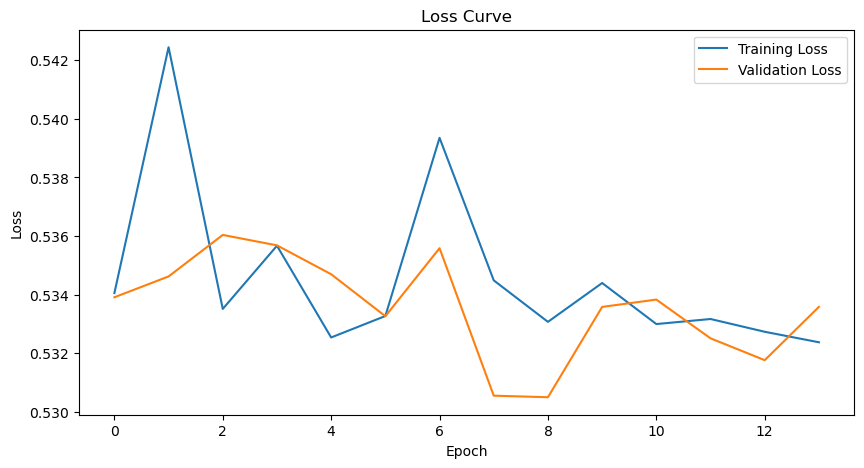

In [16]:
# Cuda issues
print(torch.__version__)
print(torch.cuda.is_available())
vocab_size = tokenizer_recipes.vocab_size
param_path = os.path.join(GOOGLE_DRIVE_PATH, "models/best_model_test.pth")
recipe_embeddings_path  = os.path.join(GOOGLE_DRIVE_PATH, "models/recipe_embeddings.pth")

kwargs = {
    'epochs': 15,
    'ingredient_tokens': filtered_df['tokenized_ingredients'].to_list(),
    'instruction_tokens': filtered_df['tokenized_instructions'].to_list(),
    'title_tokens': filtered_df['tokenized_titles'].to_list(),
    'image_tensors': filtered_tensors,
    'image_labels': filtered_df['Image_Name'],
    'device': device,
    'vocab_size': vocab_size,
    'max_len': total_max,
    'clip_model': clip_model,
    'optimizer': 'adam',
    'learning_rate': 4.18e-7,
    'batch_size': 10,
    'instance_weight': 0.698,
    'sem_weight': 16.35,
    'itm_weight': 0.0011,
    'initial_margin': 0.02,
    'margin_step': 0.094,
    'max_margin': 0.02,
    'best_model_parameters_path': param_path,
    'decoder_lambda': 0.1,
    'topk': 10,
    'patience': 20,
    'improvement_threshold': 0.001,
    'fixed_margin': 0.02,
    'mmr_heads': 4,
    'ITEM_lyrs': 1,
    'MTD_lyrs': 1,
    'recipe_enc_hidden':512

    # 'max_lengths': {
    #     'ingredient_tokens': max_length_ing,
    #     'instruction_tokens': max_length_inst,
    #     'title_tokens': max_length_title
    # }

}
image2recipe = Trainer(**kwargs)
image2recipe.train()
image2recipe.plot_learning_loss_curves()
# image2recipe.save_training_results()

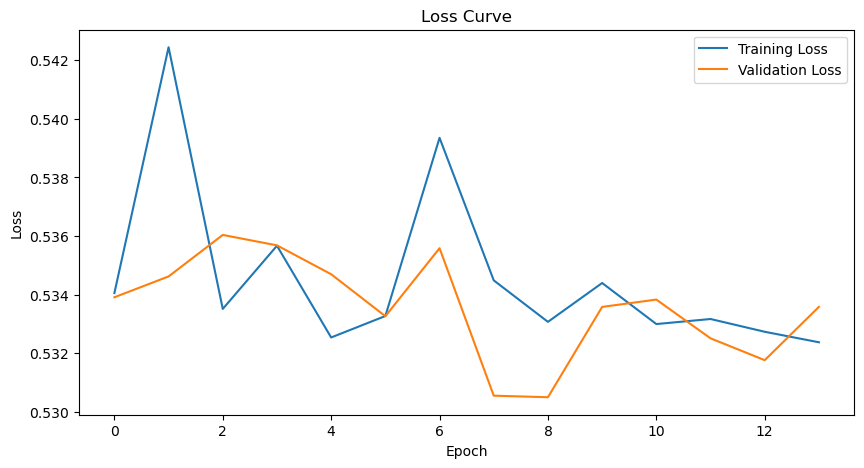

TypeError: Trainer.save_training_results() takes 1 positional argument but 2 were given

In [17]:
image2recipe.plot_learning_loss_curves()
image2recipe.save_training_results('anything')

Now that the model is trained, use it to guess images recipes!

In [ ]:
from PIL import Image
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),  #same size as training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #same norm as training
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0) #add batch dim of 1 at 0 indice

def extract_image_features(image, model, device):
  model.eval()
  with torch.no_grad():
      image_features = model.image_encoder(image.to(device))
      image_features = torch.nn.functional.normalize(image_features, p=2, dim=-1)
  return image_features

def load_model(model_path):
    image_encoder = Image_Encoder(device, clip_model, num_classes).to(device)
    recipe_encoder = RecipeEncoder(device, vocab_size, max_len).to(device)
    mmr = MMR(hidden_dim=image_encoder.clip_model.config.projection_dim).to(device)
    model = Image2Recipe(image_encoder, recipe_encoder, mmr).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

image_path = "insert test image path"
tensor_image = preprocess_image(image_path)
image2recipe = load_model(param_path)
image_features = extract_image_features(tensor_image, image2recipe.model, device)
print(image_features.shape)

recipe_embeddings = np.load(recipe_embeddings_path)


#Compute cosine similarities



In [ ]:
recipe_embeddings_path = os.path.join(GOOGLE_DRIVE_PATH, "models/recipe_embeddings.pth")

##load up the model
def load_model(model_path):
    num_classes = len(set(filtered_df['Image_Name']))
    max_len = total_max
    image_encoder = Image_Encoder(device, clip_model, num_classes).to(device)
    recipe_encoder = RecipeEncoder(device, vocab_size, max_len).to(device)
    mmr = MMR(hidden_dim=image_encoder.clip_model.config.projection_dim).to(device)
    model = Image2Recipe(image_encoder, recipe_encoder, mmr).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

model = load_model(param_path)

data_total = Data_Loading(
            filtered_df['tokenized_ingredients'].to_list(),
            filtered_df['tokenized_instructions'].to_list(),
            filtered_df['tokenized_titles'].to_list(),
            filtered_tensors,
            filtered_df['Image_Name']
        )

dataloader = DataLoader(data_total, batch_size=10, shuffle=False, drop_last=True)
##Create the recipe embedded space
all_recipe_embeddings = []
for i, batch in enumerate(dataloader):
  with torch.no_grad():
    ingredients, instructions, titles, images, image_labels = (
        batch['ingredients'].to(device),
        batch['instructions'].to(device),
        batch['titles'].to(device),
        batch['images'].to(device),
        batch['image_labels']
    )
    recipe_enc_src = [titles, ingredients, instructions]
    output = model(images, image_labels, recipe_enc_src)
    recipe_embeddings_proj = output["recipe_embeddings_proj"]
    all_recipe_embeddings.append(recipe_embeddings_proj)
    print(f"Batch: {i}/{len(dataloader)}")

recipe_embeddings_total = torch.cat(all_recipe_embeddings, dim=0)
print(recipe_embeddings_total.shape)
torch.save(recipe_embeddings_total, recipe_embeddings_path)


In [ ]:
recipe_embeddings_path = os.path.join(GOOGLE_DRIVE_PATH, "models/recipe_embeddings.pth")
recipe_embeddings = torch.load(recipe_embeddings_path)
param_path = os.path.join(GOOGLE_DRIVE_PATH, "models/best_model.pth")
vocab_size = tokenizer_recipes.vocab_size

##load up the model
def load_model(model_path):
    num_classes = len(set(filtered_df['Image_Name']))
    max_len = total_max
    image_encoder = Image_Encoder(device, clip_model, num_classes).to(device)
    recipe_encoder = RecipeEncoder(device, vocab_size, max_len).to(device)
    mmr = MMR(hidden_dim=image_encoder.clip_model.config.projection_dim).to(device)
    model = Image2Recipe(image_encoder, recipe_encoder, mmr).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()
    return model

model = load_model(param_path)

data_total = Data_Loading(
            filtered_df['tokenized_ingredients'].to_list(),
            filtered_df['tokenized_instructions'].to_list(),
            filtered_df['tokenized_titles'].to_list(),
            filtered_tensors,
            filtered_df['Image_Name']
        )

dataloader = DataLoader(data_total, batch_size=10, shuffle=False, drop_last=True)
##Create the recipe embedded space
all_recipe_embeddings = []
for i, batch in enumerate(dataloader):
  with torch.no_grad():
    ingredients, instructions, titles, images, image_labels = (
        batch['ingredients'].to(device),
        batch['instructions'].to(device),
        batch['titles'].to(device),
        batch['images'].to(device),
        batch['image_labels']
    )
    recipe_enc_src = [titles, ingredients, instructions]
    output = model(images, image_labels, recipe_enc_src)
    image_embeddings_proj = output["image_embeddings_proj"]
    recall_score = calc_recall(10, image_embeddings_proj, recipe_embeddings, filtered_df['Image_Name'].to_list())
    print(recall_score)
    print(f"Batch: {i}/{len(d)}")

In [ ]:
from PIL import Image
import torchvision.transforms as transforms
recipe_embeddings_path = os.path.join(GOOGLE_DRIVE_PATH, "models/recipe_embeddings.pth")
transform = transforms.Compose([
    transforms.Resize((224, 224)),  #same size as training
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) #same norm as training
])

def preprocess_image(image_path):
    image = Image.open(image_path).convert("RGB")
    return transform(image).unsqueeze(0) #add batch dim of 1 at 0 indice

def extract_image_features(image, model, device):
  model.eval()
  with torch.no_grad():
      image_logits, image_features = model.image_encoder(image.to(device), image_labels)
  return image_features

def load_model(model_path):
    num_classes = len(set(filtered_df['Image_Name']))
    max_len = total_max
    image_encoder = Image_Encoder(device, clip_model, num_classes).to(device)
    recipe_encoder = RecipeEncoder(device, vocab_size, max_len).to(device)
    mmr = MMR(hidden_dim=image_encoder.clip_model.config.projection_dim).to(device)
    model = Image2Recipe(image_encoder, recipe_encoder, mmr).to(device)
    model.load_state_dict(torch.load(model_path))
    return model

image_path = os.path.join(GOOGLE_DRIVE_PATH, "Data/test_images/pizza.png")
tensor_image = preprocess_image(image_path)
image2recipe = load_model(param_path)
image_features = extract_image_features(tensor_image, model, device)
print(image_features.shape)

recipe_embeddings = torch.load(recipe_embeddings_path)

recall_score = calc_recall(10, image_features, recipe_embeddings, filtered_df['Image_Name'].to_list())
print(recall_score)

#Compute cosine similarities